In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv("train_data.csv")

In [3]:
train.isnull().sum()

MMM-YY                      0
Emp_ID                      0
Age                         0
Gender                      0
City                        0
Education_Level             0
Salary                      0
Dateofjoining               0
LastWorkingDate         17488
Joining Designation         0
Designation                 0
Total Business Value        0
Quarterly Rating            0
dtype: int64

In [4]:
train['MMM-YY'] = pd.to_datetime(train['MMM-YY'])
train['Dateofjoining'] = pd.to_datetime(train['Dateofjoining'])
train['LastWorkingDate'] = pd.to_datetime(train['LastWorkingDate'])


In [5]:
uniqueemployeesdata= train[['Emp_ID', 'Age', 'Gender', 'City', 'Education_Level',
       'Salary', 'Dateofjoining', 'Joining Designation','Designation']].drop_duplicates()

In [6]:
employeeage = train.groupby('Emp_ID').count()['City']
employeeage = employeeage.reset_index()
employeeage.columns = ['Emp_ID','Periodwithus']
uniqueemployeesdata=  uniqueemployeesdata.merge(employeeage,on='Emp_ID',how='left')

In [7]:
uniqueemployeesdata = uniqueemployeesdata.merge(pd.pivot_table(train,index='Emp_ID',values=['Quarterly Rating'],aggfunc='mean').reset_index(),on='Emp_ID',how='left')

In [8]:
uniqueemployeesdata = uniqueemployeesdata.merge(pd.pivot_table(train,index='Emp_ID',values=['Total Business Value'],aggfunc='sum').reset_index(),on='Emp_ID',how='left')
uniqueemployeesdata['Total Business Value'] = uniqueemployeesdata['Total Business Value']/1000
uniqueemployeesdata['Salary'] = uniqueemployeesdata['Salary']/1000
uniqueemployeesdata

,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,Joining Designation,Designation,Periodwithus,Quarterly Rating,Total Business Value
0,1,28,Male,C23,Master,57.387,2015-12-24,1,1,3,2.000000,1715.58
1,2,31,Male,C7,Master,67.016,2017-11-06,2,2,2,1.000000,0.00
2,4,43,Male,C13,Master,65.603,2016-12-07,2,2,5,1.000000,350.00
3,5,29,Male,C9,College,46.368,2016-01-09,1,1,3,1.000000,120.36
4,6,31,Female,C11,Bachelor,78.728,2017-07-31,3,3,5,1.600000,1265.00
...,...,...,...,...,...,...,...,...,...,...,...,...
3781,2786,44,Male,C19,College,35.370,2015-07-31,2,2,9,1.666667,2815.09
3782,2786,45,Male,C19,College,35.370,2015-07-31,2,2,9,1.666667,2815.09
3783,2787,28,Female,C20,Master,69.498,2015-07-21,1,1,6,1.500000,977.83
3784,2788,29,Male,C27,Master,70.254,2017-06-08,2,2,7,2.285714,2298.24


In [9]:
# time business done
uniqueemployeesdata['timesbusinessdone'] = uniqueemployeesdata['Total Business Value']/uniqueemployeesdata['Salary']

In [10]:
# reversal happend for employees
reversals = train[train['Total Business Value']<0]
reversals['reversal']=1
uniqueemployeesdata=uniqueemployeesdata.merge(reversals[['Emp_ID','reversal']].drop_duplicates(),on='Emp_ID',how='left')
uniqueemployeesdata['reversal']=uniqueemployeesdata['reversal'].fillna(0)

<ipython-input-10-03f3622b63ff>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reversals['reversal']=1


In [11]:
# zero business count
zeroperformance = train[train['Total Business Value']==0]
zeroperformance = zeroperformance.groupby('Emp_ID').count()['Age'].reset_index()
zeroperformance.columns = ['Emp_ID','zeroperformance']
uniqueemployeesdata = uniqueemployeesdata.merge(zeroperformance.drop_duplicates(),on='Emp_ID',how='left')

In [12]:
# months where coverage less than salary
train['timesbusiness'] = train['Total Business Value']/train['Salary']
businesslesscoverage = train[train['timesbusiness']<1]
businesslesscoverage=businesslesscoverage.groupby('Emp_ID').count()['Age'].reset_index()
businesslesscoverage.columns=['Emp_ID','Businesslessthansalary']
uniqueemployeesdata=uniqueemployeesdata.merge(businesslesscoverage[['Emp_ID','Businesslessthansalary']].drop_duplicates(),on='Emp_ID',how='left')
uniqueemployeesdata['Businesslessthansalary']=uniqueemployeesdata['Businesslessthansalary'].fillna(0)

In [13]:
# Change in designation
changedesignation = train[train['Joining Designation'] != train['Designation']]
changedesignation['changedesignation']=1
changedesignation = changedesignation[['Emp_ID','changedesignation']].drop_duplicates()
uniqueemployeesdata = uniqueemployeesdata.merge(changedesignation[['Emp_ID','changedesignation']].drop_duplicates(),on='Emp_ID',how='left')
uniqueemployeesdata['changedesignation'] = uniqueemployeesdata['changedesignation'].fillna(0)

<ipython-input-13-7594b7acc583>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  changedesignation['changedesignation']=1


In [14]:
# Last rating before leaving
lastrating = train[['Emp_ID','Quarterly Rating']].drop_duplicates( subset='Emp_ID',keep='last')
lastrating.columns = ['Emp_ID','Last Rating']
uniqueemployeesdata = uniqueemployeesdata.merge(lastrating,on='Emp_ID',how='left')

In [15]:
# get the target column set
employeeswholeft = train[~train['LastWorkingDate'].isna()]
employeeswholeft['Y']=0
uniqueemployeesdata = uniqueemployeesdata.merge(employeeswholeft[['Emp_ID','Y']],on='Emp_ID',how='left')
uniqueemployeesdata['Y']=uniqueemployeesdata['Y'].fillna(1)

<ipython-input-15-45faf7725a26>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  employeeswholeft['Y']=0


In [16]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
uniqueemployeesdata['City'] = label.fit_transform(uniqueemployeesdata['City'])
uniqueemployeesdata['Education_Level'] = label.fit_transform(uniqueemployeesdata['Education_Level'])
uniqueemployeesdata

,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,Joining Designation,Designation,Periodwithus,Quarterly Rating,Total Business Value,timesbusinessdone,reversal,zeroperformance,Businesslessthansalary,changedesignation,Last Rating,Y
0,1,28,Male,15,2,57.387,2015-12-24,1,1,3,2.000000,1715.58,29.894924,1.0,1.0,2.0,0.0,2,0.0
1,2,31,Male,26,2,67.016,2017-11-06,2,2,2,1.000000,0.00,0.000000,0.0,2.0,2.0,0.0,1,1.0
2,4,43,Male,4,2,65.603,2016-12-07,2,2,5,1.000000,350.00,5.335122,0.0,4.0,4.0,0.0,1,0.0
3,5,29,Male,28,1,46.368,2016-01-09,1,1,3,1.000000,120.36,2.595756,0.0,2.0,2.0,0.0,1,0.0
4,6,31,Female,2,0,78.728,2017-07-31,3,3,5,1.600000,1265.00,16.067981,0.0,4.0,4.0,0.0,2,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3781,2786,44,Male,10,1,35.370,2015-07-31,2,2,9,1.666667,2815.09,79.589765,0.0,3.0,3.0,0.0,1,0.0
3782,2786,45,Male,10,1,35.370,2015-07-31,2,2,9,1.666667,2815.09,79.589765,0.0,3.0,3.0,0.0,1,0.0
3783,2787,28,Female,12,2,69.498,2015-07-21,1,1,6,1.500000,977.83,14.069901,0.0,3.0,3.0,0.0,1,0.0
3784,2788,29,Male,19,2,70.254,2017-06-08,2,2,7,2.285714,2298.24,32.713297,0.0,2.0,2.0,0.0,2,1.0


In [17]:
uniqueemployeesdata = uniqueemployeesdata.groupby(['Emp_ID'])['Emp_ID','Age','Gender','City','Education_Level','Salary','Dateofjoining','Joining Designation','Designation','Y','Periodwithus','Quarterly Rating','Total Business Value','timesbusinessdone','reversal','zeroperformance','Businesslessthansalary','changedesignation','Last Rating'].tail(1)

<ipython-input-17-ab8a8b6b1aa2>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  uniqueemployeesdata = uniqueemployeesdata.groupby(['Emp_ID'])['Emp_ID','Age','Gender','City','Education_Level','Salary','Dateofjoining','Joining Designation','Designation','Y','Periodwithus','Quarterly Rating','Total Business Value','timesbusinessdone','reversal','zeroperformance','Businesslessthansalary','changedesignation','Last Rating'].tail(1)


In [18]:
uniqueemployeesdata.reset_index(inplace = True,drop = True)
uniqueemployeesdata.drop(["Dateofjoining"],axis = 1, inplace = True)
uniqueemployeesdata

,Emp_ID,Age,Gender,City,Education_Level,Salary,Joining Designation,Designation,Y,Periodwithus,Quarterly Rating,Total Business Value,timesbusinessdone,reversal,zeroperformance,Businesslessthansalary,changedesignation,Last Rating
0,1,28,Male,15,2,57.387,1,1,0.0,3,2.000000,1715.58,29.894924,1.0,1.0,2.0,0.0,2
1,2,31,Male,26,2,67.016,2,2,1.0,2,1.000000,0.00,0.000000,0.0,2.0,2.0,0.0,1
2,4,43,Male,4,2,65.603,2,2,0.0,5,1.000000,350.00,5.335122,0.0,4.0,4.0,0.0,1
3,5,29,Male,28,1,46.368,1,1,0.0,3,1.000000,120.36,2.595756,0.0,2.0,2.0,0.0,1
4,6,31,Female,2,0,78.728,3,3,1.0,5,1.600000,1265.00,16.067981,0.0,4.0,4.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,2784,34,Male,16,1,82.815,2,3,1.0,24,2.625000,21748.82,262.619332,0.0,2.0,2.0,1.0,4
2377,2785,34,Female,28,1,12.105,1,1,0.0,3,1.000000,0.00,0.000000,0.0,3.0,3.0,0.0,1
2378,2786,45,Male,10,1,35.370,2,2,0.0,9,1.666667,2815.09,79.589765,0.0,3.0,3.0,0.0,1
2379,2787,28,Female,12,2,69.498,1,1,0.0,6,1.500000,977.83,14.069901,0.0,3.0,3.0,0.0,1


<AxesSubplot:>

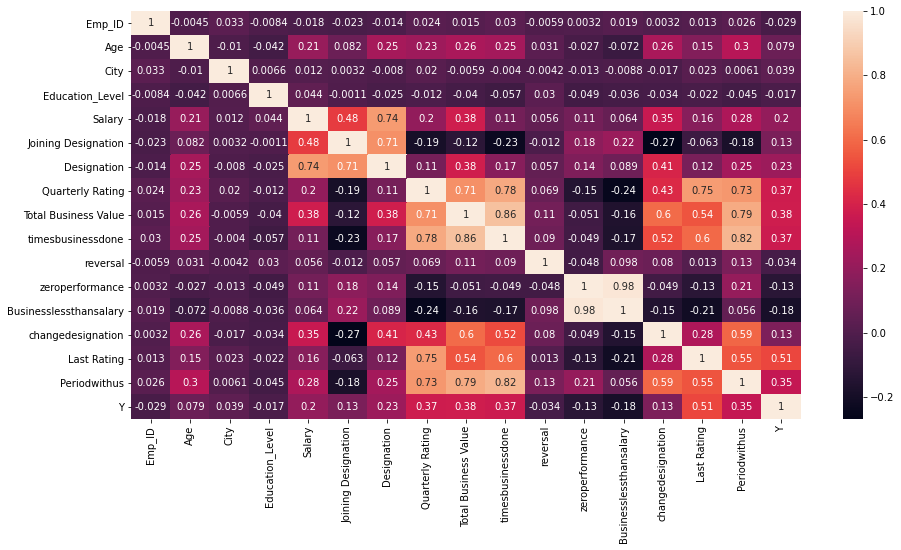

In [19]:
plt.figure(figsize=(15,7.5))
uniqueemployeesdata=uniqueemployeesdata[['Emp_ID', 'Age', 'City', 'Education_Level', 'Salary',
       'Joining Designation', 'Designation', 'Quarterly Rating',
       'Total Business Value', 'Gender',
       'timesbusinessdone','reversal','zeroperformance','Businesslessthansalary','changedesignation','Last Rating','Periodwithus','Y']]
df4_corr=uniqueemployeesdata.corr()
sns.heatmap(df4_corr,annot=True)

C:\Users\Sneha\VIT\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


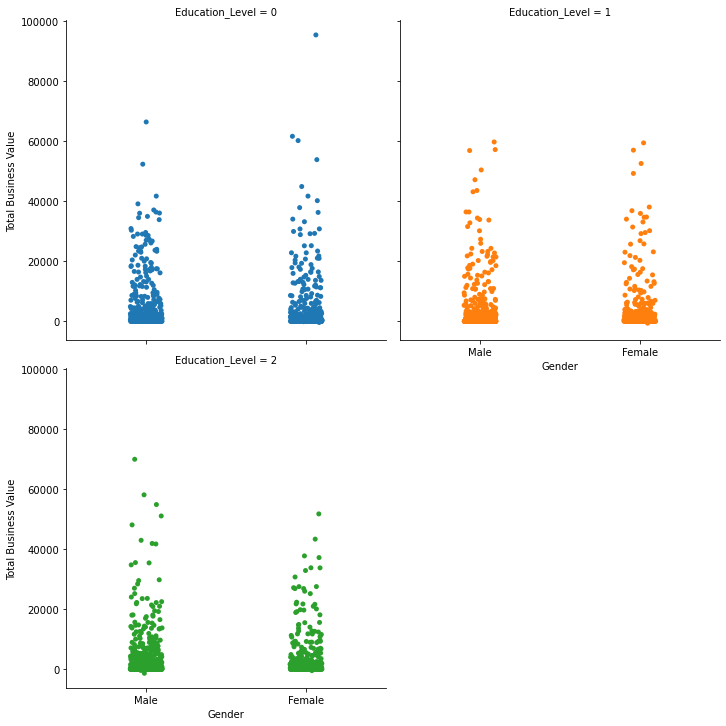

In [20]:
sns.catplot('Gender','Total Business Value',hue = 'Education_Level',data = uniqueemployeesdata ,col = 'Education_Level',col_wrap = 2)

C:\Users\Sneha\VIT\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


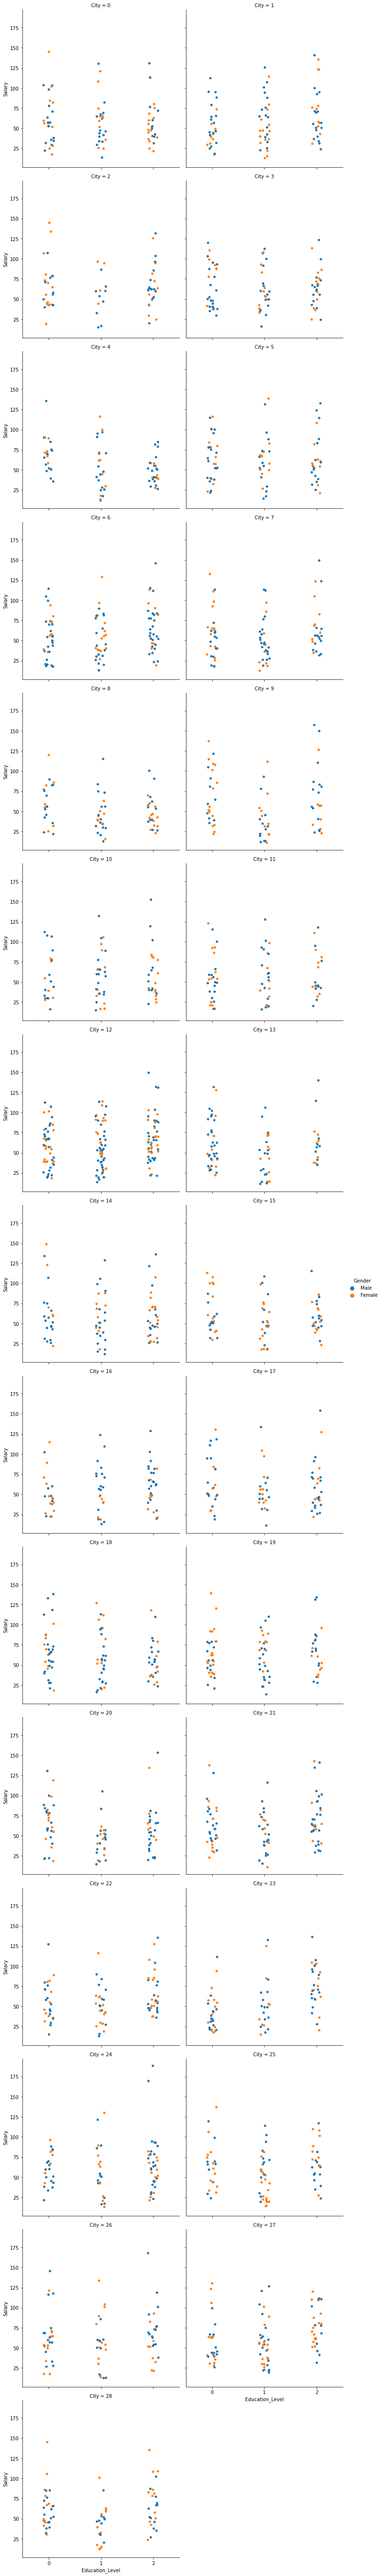

In [21]:
sns.catplot('Education_Level','Salary',data = uniqueemployeesdata,hue = 'Gender',col = 'City',col_wrap = 2)

C:\Users\Sneha\VIT\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Sneha\VIT\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Sneha\VIT\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Sneha\VIT\lib\site-packages\seaborn\_dec

<AxesSubplot:xlabel='Designation', ylabel='count'>

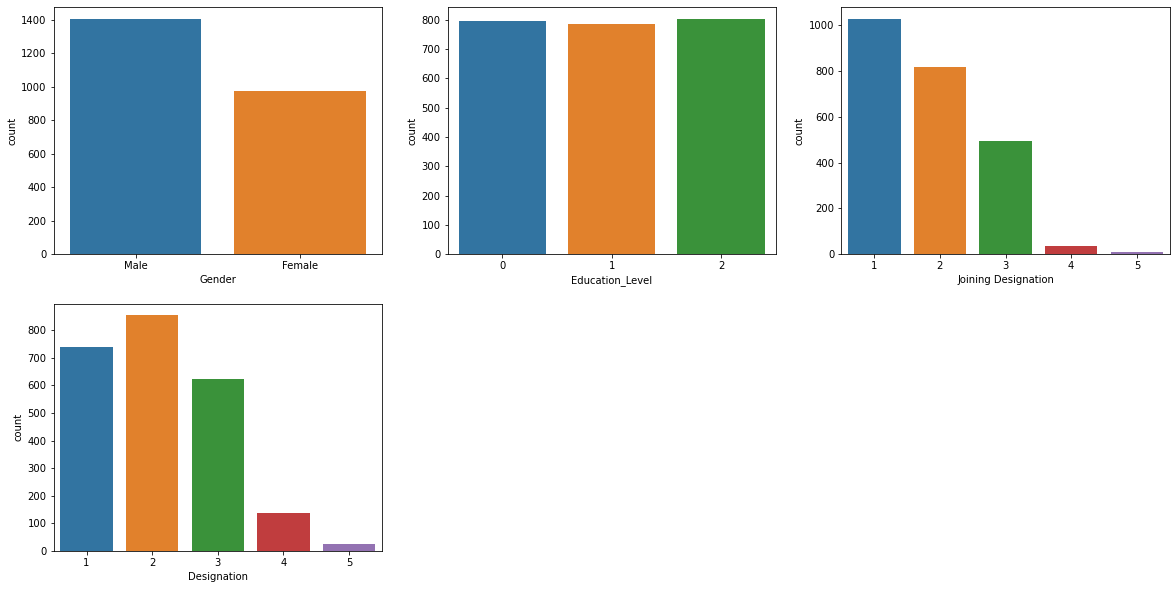

In [22]:
plt.subplots(figsize=(20,10))

plt.subplot(231)
sns.countplot('Gender',data = uniqueemployeesdata)

plt.subplot(232)
sns.countplot('Education_Level',data = uniqueemployeesdata)

plt.subplot(233)
sns.countplot('Joining Designation',data = uniqueemployeesdata)

plt.subplot(234)
sns.countplot('Designation',data = uniqueemployeesdata)

C:\Users\Sneha\VIT\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Y', ylabel='count'>

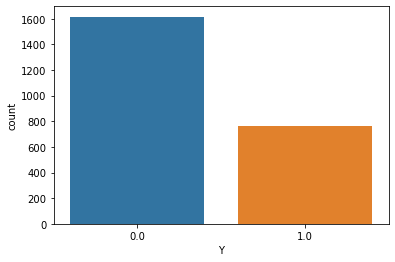

In [23]:
sns.countplot('Y',data = uniqueemployeesdata )

In [24]:
uniqueemployeesdata.drop(["Emp_ID","reversal","changedesignation","zeroperformance"],axis = 1, inplace = True)

C:\Users\Sneha\VIT\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [25]:
uniqueemployeesdata.head(38)

,Age,City,Education_Level,Salary,Joining Designation,Designation,Quarterly Rating,Total Business Value,Gender,timesbusinessdone,Businesslessthansalary,Last Rating,Periodwithus,Y
0,28,15,2,57.387,1,1,2.000000,1715.58,Male,29.894924,2.0,2,3,0.0
1,31,26,2,67.016,2,2,1.000000,0.00,Male,0.000000,2.0,1,2,1.0
2,43,4,2,65.603,2,2,1.000000,350.00,Male,5.335122,4.0,1,5,0.0
3,29,28,1,46.368,1,1,1.000000,120.36,Male,2.595756,2.0,1,3,0.0
4,31,2,0,78.728,3,3,1.600000,1265.00,Female,16.067981,4.0,2,5,1.0
5,34,11,1,70.656,3,3,1.000000,0.00,Male,0.000000,3.0,1,3,0.0
6,28,10,2,42.172,1,1,1.000000,0.00,Female,0.000000,1.0,1,1,1.0
7,35,15,2,28.116,1,1,2.500000,2607.18,Male,92.729407,3.0,1,6,0.0
8,31,10,2,119.227,1,4,1.260870,10213.04,Male,85.660463,4.0,1,23,0.0
9,39,18,1,19.734,3,3,1.000000,0.00,Female,0.000000,3.0,1,3,1.0


In [26]:
from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()

uniqueemployeesdata['City'] = label.fit_transform(uniqueemployeesdata['City'])
uniqueemployeesdata['Gender'] = label.fit_transform(uniqueemployeesdata['Gender'])
uniqueemployeesdata['Education_Level'] = label.fit_transform(uniqueemployeesdata['Education_Level'])

<ipython-input-26-dc2c51075983>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uniqueemployeesdata['City'] = label.fit_transform(uniqueemployeesdata['City'])
<ipython-input-26-dc2c51075983>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uniqueemployeesdata['Gender'] = label.fit_transform(uniqueemployeesdata['Gender'])
<ipython-input-26-dc2c51075983>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [27]:
uniqueemployeesdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     2381 non-null   int64  
 1   City                    2381 non-null   int64  
 2   Education_Level         2381 non-null   int64  
 3   Salary                  2381 non-null   float64
 4   Joining Designation     2381 non-null   int64  
 5   Designation             2381 non-null   int64  
 6   Quarterly Rating        2381 non-null   float64
 7   Total Business Value    2381 non-null   float64
 8   Gender                  2381 non-null   int32  
 9   timesbusinessdone       2381 non-null   float64
 10  Businesslessthansalary  2381 non-null   float64
 11  Last Rating             2381 non-null   int64  
 12  Periodwithus            2381 non-null   int64  
 13  Y                       2381 non-null   float64
dtypes: float64(6), int32(1), int64(7)
memory

In [28]:
x  = uniqueemployeesdata.iloc[:,0:13].values
y = uniqueemployeesdata.iloc[:,13:].values
y

array([[0.],
       [1.],
       [0.],
       ...,
       [0.],
       [0.],
       [1.]])

In [66]:
x

array([[28., 15.,  2., ...,  2.,  2.,  3.],
       [31., 26.,  2., ...,  2.,  1.,  2.],
       [43.,  4.,  2., ...,  4.,  1.,  5.],
       ...,
       [45., 10.,  1., ...,  3.,  1.,  9.],
       [28., 12.,  2., ...,  3.,  1.,  6.],
       [30., 19.,  2., ...,  2.,  2.,  7.]])

In [29]:
y

array([[0.],
       [1.],
       [0.],
       ...,
       [0.],
       [0.],
       [1.]])

In [30]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size = 0.3, random_state = 1)

In [31]:
print(x_train)  
print(y_train)

[[30. 19.  2. ...  2.  2.  7.]
 [41.  0.  2. ...  3.  1.  7.]
 [37.  2.  2. ...  3.  1.  6.]
 ...
 [34. 12.  0. ...  3.  1.  3.]
 [43. 12.  0. ...  2.  1.  3.]
 [31.  2.  0. ...  2.  1.  5.]]
[[1.]
 [0.]
 [0.]
 ...
 [0.]
 [1.]
 [0.]]


In [32]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(x_train, y_train)

LinearRegression()

In [33]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [60]:
SVC_model = SVC()
KNN_model = KNeighborsClassifier(n_neighbors=100)

In [61]:
SVC_model.fit(x_train, y_train)
KNN_model.fit(x_train, y_train)

C:\Users\Sneha\VIT\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Sneha\VIT\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=100)

In [62]:
SVC_prediction = SVC_model.predict(x_test)
KNN_prediction = KNN_model.predict(x_test)

In [63]:
print(accuracy_score(SVC_prediction, y_test))
print(accuracy_score(KNN_prediction, y_test))

0.7832167832167832
0.7832167832167832


In [64]:
print(confusion_matrix(SVC_prediction, y_test))
print(classification_report(KNN_prediction, y_test))

[[491 136]
 [ 19  69]]
              precision    recall  f1-score   support

         0.0       0.96      0.78      0.86       627
         1.0       0.34      0.78      0.47        88

    accuracy                           0.78       715
   macro avg       0.65      0.78      0.67       715
weighted avg       0.89      0.78      0.82       715



In [65]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.2998326283499379
Mean Squared Error: 0.14075973027376595
Root Mean Squared Error: 0.3751795973580732


In [36]:
type(y)

numpy.ndarray

In [37]:
print(regressor.intercept_)

[0.12668195]


In [38]:
print(regressor.coef_)

[[-6.04109887e-03  1.19475179e-03 -6.40861349e-03  6.24332833e-05
   1.80880293e-01 -6.52072262e-02 -1.55307645e-01  1.00781273e-05
   1.63254007e-02 -7.22965656e-06 -4.73071042e-02  2.75881695e-01
   1.65868668e-02]]
